# Semivariogram exploration

Rushing into Kriging is a bad idea. You can interpolate values automatically but never know if a process is spatially dependent. The kriging model will return something even when there is no spatial dependency, and it is a dangerous situation because the output might look correct, being wildly wrong.

The easiest way to deal with this problem is to check the variogram before modeling. Feel obligated to do this manual step because it could save you time and money! Variograms will tell you if there is a spatial relation between point pairs and how distance defines it.

In this exercise, we compute the experimental semivariogram, check it, and apply different theoretical models to find the best fit.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
- **Package**:
  - installation
- **Programming**:
  - Python basics

## Table of contents

1. Data preparation
2. Create the experimental variogram
3. Set manually different semivariogram models
4. Fit the theoretical model automatically
5. Export model
6. Import model

## Dataset

Dataset in this tutorial is the Digital Elevation Model around Gorzów Wielkopolski city in Poland.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyinterpolate import reproject_flat, ExperimentalVariogram, build_theoretical_variogram, TheoreticalVariogram

## Chapter 1: data preparation

In [2]:
DEM_FILE = '../data/dem.csv'

In [3]:
df = pd.read_csv(DEM_FILE)
df.head()

,longitude,latitude,dem
0,15.115241,52.765146,91.275597
1,15.115241,52.742790,96.548294
2,15.115241,52.710706,51.254551
3,15.115241,52.708844,48.958282
4,15.115241,52.671378,16.817863


Data is stored in EPSG:4326 and has geographic coordinates, it must be reprojected to projected coordinate reference system. Polish area can be projected into EPSG:2180 (metric).

We cannot reproject points easily, first we need to transform `longitude` and `latitude` columns into shapely `Point()` objects, and set **CRS**, and in the next step we can transform those points into EPSG:2180. `Pyinterpolate` has function `reproject_flat()` which takes care of all those steps and returns the same object type as input to it (numpy array or pandas DataFrame).

In [4]:
r_df = reproject_flat(
    ds=df,
    in_crs=4326,
    out_crs=2180,
    lon_col='longitude',
    lat_col='latitude'
)

In [5]:
r_df.head()

,dem,longitude,latitude
0,91.275597,238012.301750,551466.805222
1,96.548294,237878.001294,548982.351111
2,51.254551,237685.325393,545416.708315
3,48.958282,237674.140301,545209.671315
4,16.817863,237449.254870,541045.934750


We might transform this `DataFrame` into `GeoDataFrame` - mostly for plotting purposes, to see what lies behind this dataset.

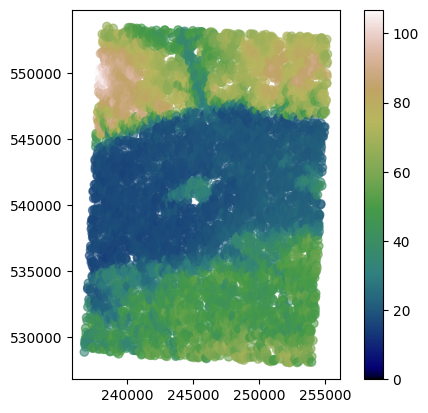

In [6]:
dem_geometry = gpd.points_from_xy(x=r_df['longitude'], y=r_df['latitude'], crs=2180)
dem = gpd.GeoDataFrame(r_df, geometry=dem_geometry)

dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

Data covers almost whole area, and this scenario is not realistic, so we will let only 1% of points in a dataset and then proceed to the variogram analysis and modeling.

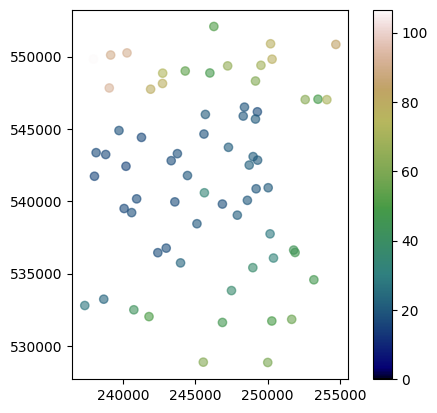

In [7]:
sample = dem.sample(int(0.01 * len(dem)))
sample.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

## Chapter 2: Experimental Variogram

To be sure that we can interpolate missing values with Kriging we must check if there is any relation between observation pairs, and how strong is this relation. We use variograms - plots of the dissimilarity between point pairs along the increasing distance. There are two "types" of variograms that we must be aware of:

- The experimental (semi)variogram: directly showing differences between point pairs at specific distances - lags. It could be very messy. We use it to visually check if there is a spatial correlation.
- Theoretical (semi)variogram: is a function applied to the experimental variogram. It cannot be any function, there are few of those in literature (and implemented in `pyinterpolate`). We can apply those mappings manually or automatically minimizing OLS error between experimental POINTS and theoretical FUNCTION.

We start our analysis by setting up the experimental model. We use class `ExperimentalVariogram` to set up the object (the class has an alias function `build_experimental_variogram()` but we won't use it). Class takes multiple parameters:

- `ds` : numpy array - ``[x, y, value]``
- `step_size` : float - The fixed distance between lags grouping point neighbors.
- `max_range` : float - The maximum distance at which the semivariance is calculated.
- `direction` : float, optional - Direction of semivariogram, values from 0 to 360 degrees.
- `tolerance` : float, optional - Controlling the cone within points are treated as neighbors in directional variogram.
- `custom_bins` : numpy array, optional - Custom lags (new in Pyinterpolate 1.x).
- `custom_weights` : numpy array, optional - Custom weights assigned to points. Only semivariance values are weighted.
- `is_semivariance` : bool, default=True - Calculate experimental semivariance.
- `is_covariance` : bool, default=True - Calculate experimental coviariance.
- `as_cloud` : bool, default=False - Calculate semivariance point-pairs cloud.

We won't set `direction`, `tolerance`, `custom_bins`, `custom_weights`, and `as_cloud` parameters. Other parameters are set as in the cell below.

In [8]:
step_size = 1000  # meters - remember, that this parameter is related to projection!
max_range = 20000  # meters - remember, that this parameter is related to projection!

is_semivariance = True
is_covariance = True

ds = sample[['longitude', 'latitude', 'dem']].to_numpy()

In [9]:
experimental_variogram = ExperimentalVariogram(
    ds=ds,
    step_size=step_size,
    max_range=max_range,
    is_semivariance=is_semivariance,
    is_covariance=is_covariance
) 

The `ExperimentalVariogram` object might represent:

- **semivariance**: dissimilarity over a distance, and point cloud semivariances - non-averaged dissimilarities between point pairs,
- **covariance**: similarity over a distance,
- **variance**: non-spatial variance of all points.
- 
The class has two useful methods:

1. We can print object statistics with the `print()` function,
2. We can plot semivariance, covariance, and variance and check how they behave with the `.plot()` method.

Let's check both!

In [10]:
print(experimental_variogram)

+---------+--------------------+---------------------+
|   lag   |    semivariance    |      covariance     |
+---------+--------------------+---------------------+
|  1000.0 | 22.839572575761256 |  500.53012844628506 |
|  2000.0 | 54.77666867567983  |  495.28722707255264 |
|  3000.0 | 73.55387720158612  |  514.3168259479716  |
|  4000.0 | 247.64475096252215 |  239.57763215085873 |
|  5000.0 | 374.26488763145153 |  149.17675858856276 |
|  6000.0 | 393.4885870592367  |  76.39537536151715  |
|  7000.0 | 614.2879401577181  |  -52.10264454363108 |
|  8000.0 | 604.4220102928075  |  -54.08738093407382 |
|  9000.0 | 654.0737107006238  |  -65.67570459557591 |
| 10000.0 |  644.098131554541  | -123.96561380137695 |
| 11000.0 | 741.1397843293528  | -136.32211764589368 |
| 12000.0 | 799.9484236339671  |  -135.2720988551175 |
| 13000.0 | 787.3614486236338  | -183.95247084934357 |
| 14000.0 | 956.7908708077721  | -310.01806187459914 |
| 15000.0 | 893.0678246611317  |  -272.9525163748018 |
| 16000.0 

- **Lag** is a column with the lag center,
- **semivariance** is a column with a dissimilarity metric,
- **covariance** is a column with a similarity metric,

We can plot semivariance and covariance to understand their relation.

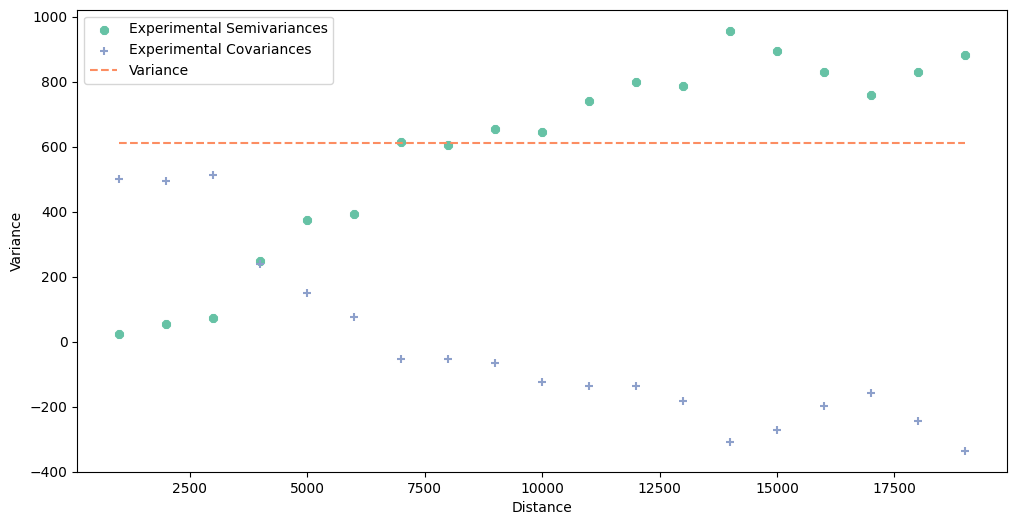

In [11]:
experimental_variogram.plot(
    semivariance=True,
    covariance=True,
    variance=True
)

Our plot shows three objects:

- **Circles** represent semivariance,
- **Plus signs** represent covariance,
- **The dashed line** is a variance.
- 
We see here that semivariance and covariance are mirrored. What does it mean? It is normal behavior, and we should expect it - semivariance and covariance have symmetrical trends (they differ in a sign). We can read it as:

- **semivariances** show that the dissimilarity between point pairs over a distance increases,
- **covariances** show that the similarity between point pairs over a distance decreases.

In the best-case scenario (data is stationary, e.g., mean and variance don't change with a distance), variance and covariance should be equal to semivariance.

## Chapter 3: Theoretical Variogram

### Manual setting

We can start modeling theoretical function that optimally describes observed data. Our role is to choose the function type and set three hyperparameters: *nugget*, *sill*, and *range*. You can read more about semivariogram models here: [Geostatistics: Theoretical Variogram Models](https://ml-gis-service.com/index.php/2022/04/01/geostatistics-theoretical-variogram-models/).

Semivariogram has three basic properties:

- **nugget**: the initial value at a zero distance. In most cases, it is zero, but sometimes it represents a bias.
- **sill**: a distance where the semivariogram flattens and reaches approximately 95% of dissimilarity. Sometimes we cannot find a sill; for example, if differences grow exponentially, but in pyinterpolate it is usually set close to the variance of data,
- **range**: is a distance where a variogram reaches its sill. Larger distances are negligible for interpolation.

We are not forced to know all of them at the beginning. The package may easily derive them all with the class `TheoriticalVariogram.autofit()` method.

We can create a theoretical model in two ways:

1. Manually, setting model type, nugget, sill, and range.
2. Semi-automatically, leaving some parameters (from the above) not filled. We will do it in the next chapter.

### Models

We can choose from a set of predefined models:

- circular
- cubic
- exponential
- gaussian
- linear
- power
- spherical

We will set the following:

- **sill** to the experimental variogram variance, (but it might be set to the the last five lags average value of semivariances),
- **nugget** to zero,
- **range** to 8000 (we see in the experimental variogram plot that the semivariance *flattens* around this range, and it becomes close to the variance).

In [12]:
sill = experimental_variogram.variance
nugget = 0
variogram_range = 8000

In [13]:
# circular

circular_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                             models_group='circular',
                                             sill=sill,
                                             rang=variogram_range,
                                             nugget=nugget)

In [14]:
print(circular_model)

* Selected model: Circular model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 174.69058258248637
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 97.21087115010836  | 22.839572575761256 |  -74.37129857434711 |
|  2000.0 | 192.88056917612985 | 54.77666867567983  | -138.10390050045004 |
|  3000.0 | 285.39047146298935 | 73.55387720158612  | -211.83659426140323 |
|  4000.0 | 372.94564200492954 | 247.64475096252215 | -125.30089104240739 |
|  5000.0 | 453.4170844115369  | 374.26488763145153 |  -79.15219678008538 |
|  6000.0 | 524.0281292806216  | 393.4885870592367  | -130.53954222138486 |
|  7000.0 | 580.5201470668635  | 614.2879401577181  |  33.767793

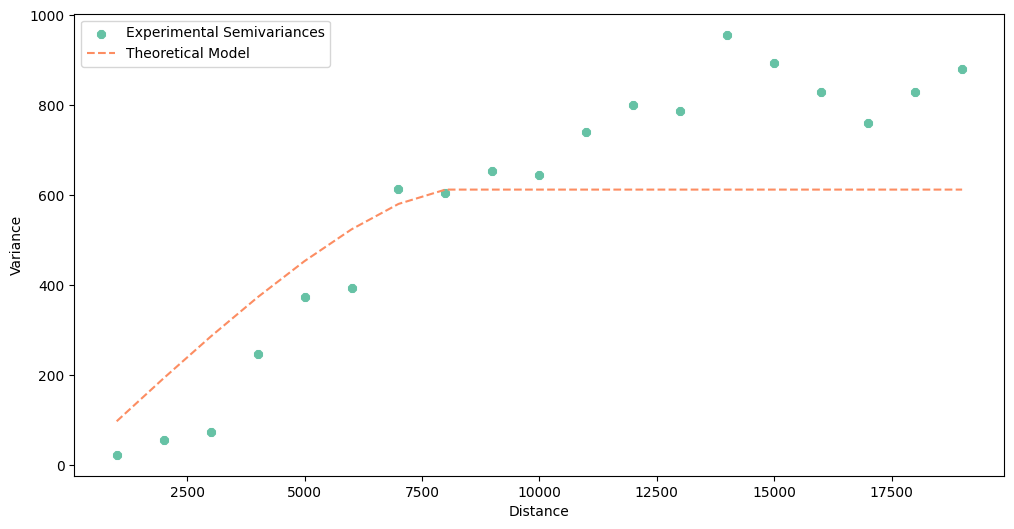

In [15]:
circular_model.plot()

In [16]:
# cubic

cubic_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                          models_group='cubic',
                                          sill=sill,
                                          rang=variogram_range,
                                          nugget=nugget)

In [17]:
print(cubic_model)

* Selected model: Cubic model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 188.99914468270734
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 56.57992431848589  | 22.839572575761256 |  -33.74035174272463 |
|  2000.0 | 186.26127117075512 | 54.77666867567983  |  -131.4846024950753 |
|  3000.0 | 335.6659490549286  | 73.55387720158612  |  -262.1120718533425 |
|  4000.0 | 465.2747310557487  | 247.64475096252215 | -217.62998009322655 |
|  5000.0 | 553.5971787025009  | 374.26488763145153 | -179.33229107104933 |
|  6000.0 | 598.0301557044678  | 393.4885870592367  |  -204.5415686452311 |
|  7000.0 | 611.3011281897615  | 614.2879401577181  |  2.9868119679

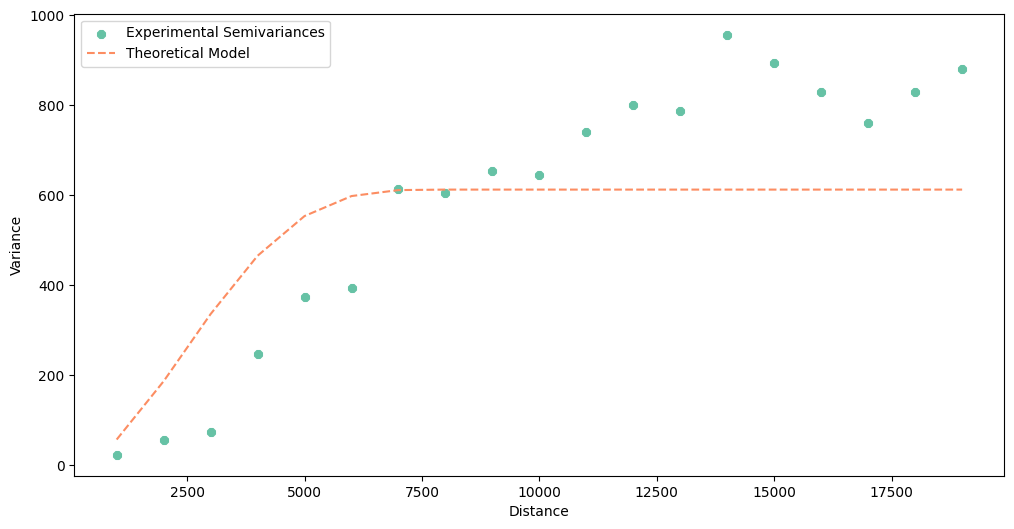

In [18]:
cubic_model.plot()

In [19]:
# Exponential model

exponential_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                                models_group='exponential',
                                                sill=sill,
                                                rang=variogram_range,
                                                nugget=nugget)
print(exponential_model)

* Selected model: Exponential model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 250.23099466243656
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 71.95800948242399  | 22.839572575761256 |  -49.11843690666274 |
|  2000.0 | 135.46072996681616 | 54.77666867567983  |  -80.68406129113633 |
|  3000.0 | 191.50168409998756 | 73.55387720158612  | -117.94780689840144 |
|  4000.0 | 240.9576525403967  | 247.64475096252215 |  6.687098422125445  |
|  5000.0 | 284.60239150337924 | 374.26488763145153 |  89.66249612807229  |
|  6000.0 | 323.11873845232464 | 393.4885870592367  |  70.36984860691206  |
|  7000.0 | 357.1092953336425  | 614.2879401577181  |  257.17

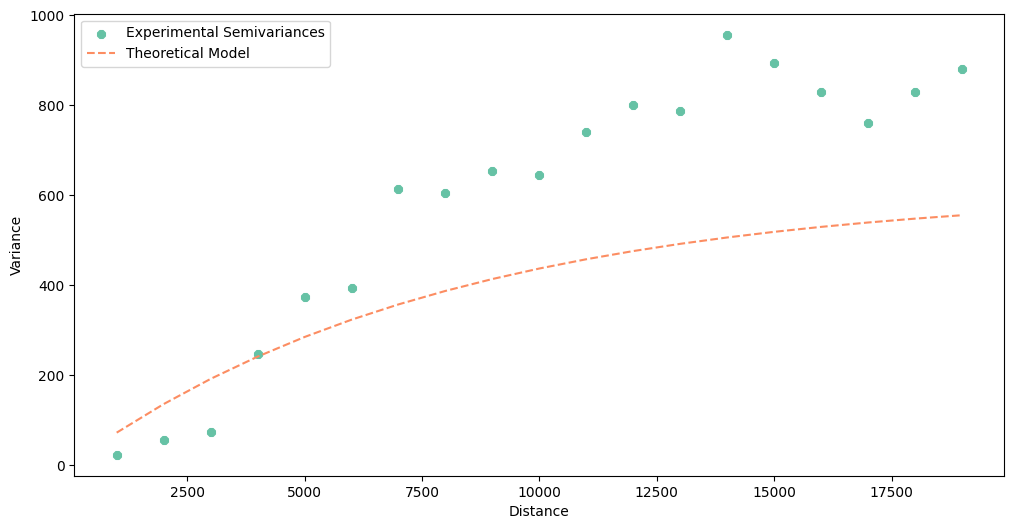

In [20]:
exponential_model.plot()

In [21]:
# Gaussian model

gaussian_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                             models_group='gaussian',
                                             sill=sill,
                                             rang=variogram_range,
                                             nugget=nugget)
print(gaussian_model)

* Selected model: Gaussian model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 211.30895879361557
* Error-lag weighting method: equal


+---------+--------------------+--------------------+--------------------+
|   lag   |    theoretical     |    experimental    |  bias (real-yhat)  |
+---------+--------------------+--------------------+--------------------+
|  1000.0 |  9.49426489611772  | 22.839572575761256 | 13.345307679643536 |
|  2000.0 | 37.10298278492342  | 54.77666867567983  | 17.67368589075641  |
|  3000.0 | 80.33666884556558  | 73.55387720158612  | -6.782791643979465 |
|  4000.0 | 135.46072996681616 | 247.64475096252215 | 112.18402099570599 |
|  5000.0 | 198.02699057309079 | 374.26488763145153 | 176.23789705836074 |
|  6000.0 | 263.4617491662428  | 393.4885870592367  | 130.0268378929939  |
|  7000.0 | 327.6035116321138  | 614.2879401577181  | 286.68442852560435 

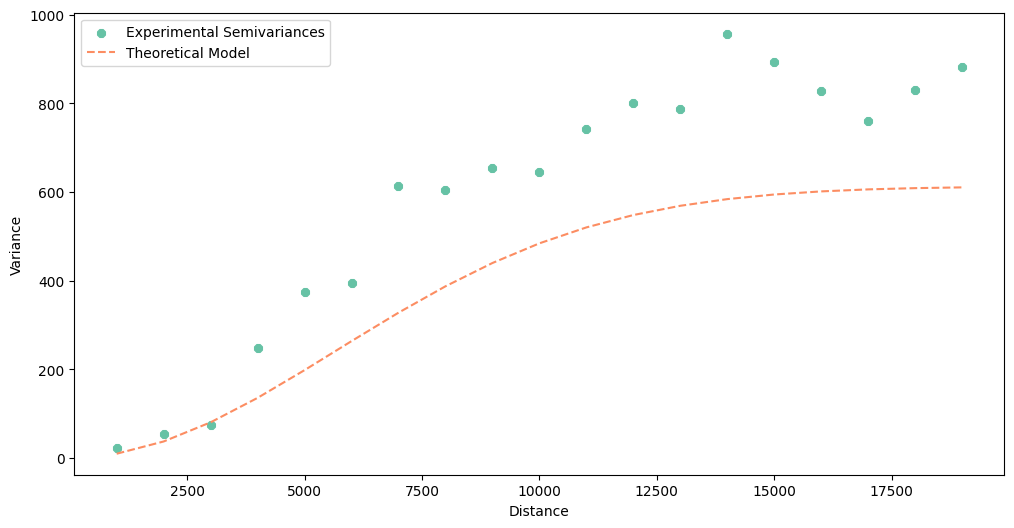

In [22]:
gaussian_model.plot()

In [23]:
# Linear model

linear_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                           models_group='linear',
                                           sill=sill,
                                           rang=variogram_range,
                                           nugget=nugget)
print(linear_model)

* Selected model: Linear model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 165.6082123142918
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 76.54905600917202  | 22.839572575761256 |  -53.70948343341077 |
|  2000.0 | 153.09811201834404 | 54.77666867567983  |  -98.32144334266421 |
|  3000.0 | 229.64716802751605 | 73.55387720158612  | -156.09329082592993 |
|  4000.0 | 306.1962240366881  | 247.64475096252215 | -58.551473074165926 |
|  5000.0 | 382.7452800458601  | 374.26488763145153 |  -8.480392414408584 |
|  6000.0 | 459.2943360550321  | 393.4885870592367  |  -65.8057489957954  |
|  7000.0 | 535.8433920642042  | 614.2879401577181  |  78.444548093

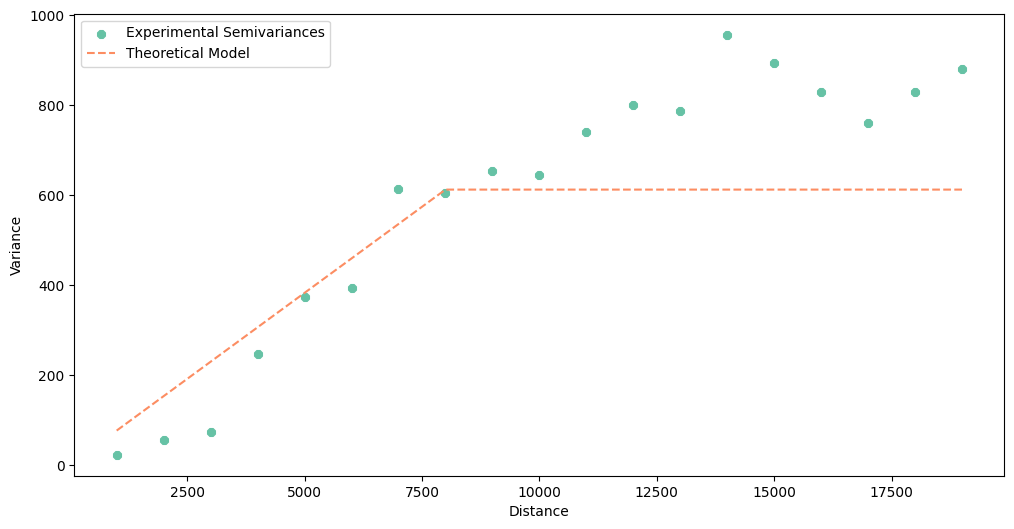

In [24]:
linear_model.plot()

In [25]:
# Power model

power_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                          models_group='power',
                                          sill=sill,
                                          rang=variogram_range,
                                          nugget=nugget)
print(power_model)

* Selected model: Power model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 165.6771170538389
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 9.568632001146502  | 22.839572575761256 |  13.270940574614754 |
|  2000.0 | 38.27452800458601  | 54.77666867567983  |  16.50214067109382  |
|  3000.0 | 86.11768801031852  | 73.55387720158612  | -12.563810808732399 |
|  4000.0 | 153.09811201834404 | 247.64475096252215 |  94.54663894417811  |
|  5000.0 | 239.21580002866256 | 374.26488763145153 |  135.04908760278897 |
|  6000.0 | 344.47075204127407 | 393.4885870592367  |  49.017835017962625 |
|  7000.0 | 468.8629680561786  | 614.2879401577181  |  145.424972101

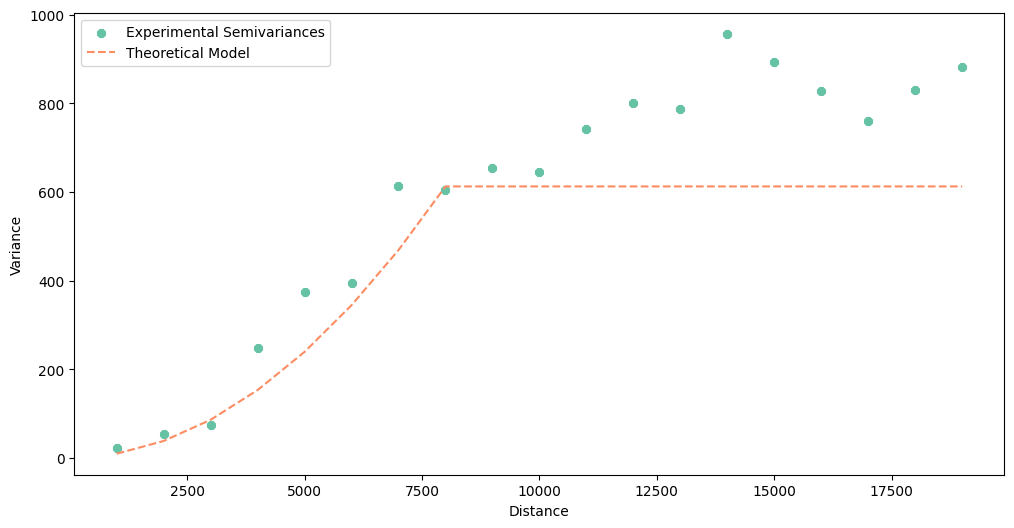

In [26]:
power_model.plot()

In [27]:
# Spherical model

spherical_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                              models_group='spherical',
                                              sill=sill,
                                              rang=variogram_range,
                                              nugget=nugget)

print(spherical_model)

* Selected model: Spherical model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 184.3886098746068
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 114.22554451368637 | 22.839572575761256 |  -91.38597193792512 |
|  2000.0 | 224.86285202694282 | 54.77666867567983  |  -170.086183351263  |
|  3000.0 | 328.32368553933935 | 73.55387720158612  | -254.76980833775323 |
|  4000.0 | 421.0198080504461  | 247.64475096252215 | -173.37505708792395 |
|  5000.0 | 499.3629825598331  | 374.26488763145153 | -125.09809492838156 |
|  6000.0 | 559.7649720670704  | 393.4885870592367  |  -166.2763850078337 |
|  7000.0 | 598.6375395717281  | 614.2879401577181  |  15.650400

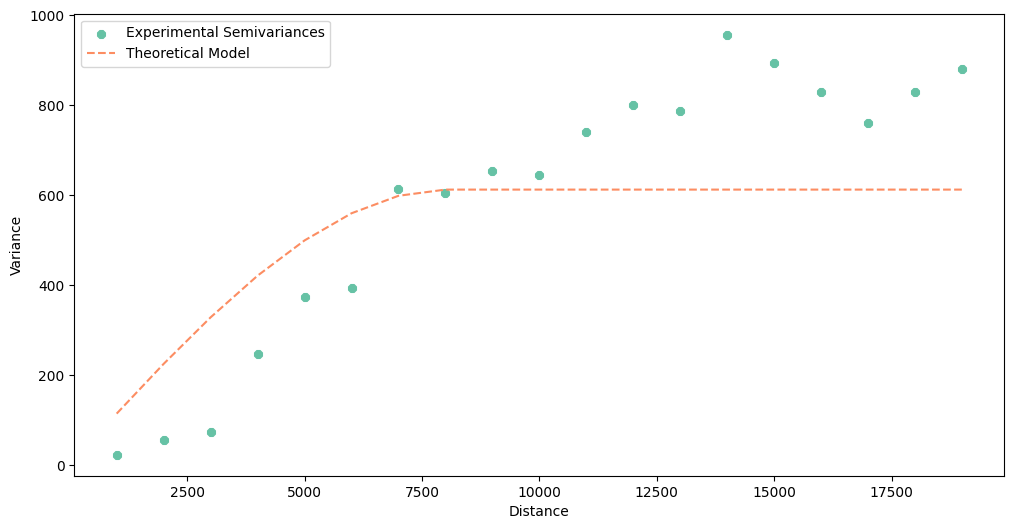

In [28]:
spherical_model.plot()

A quick look into Root Mean Squared Errors (RMSE), and we can bet that the best model is **linear**. We can check each table printed with the `print()` manually, but instead, we will automatically select model with the lowest RMSE to be sure that we have chosen the best function.

In [29]:
models = [
    circular_model, cubic_model, exponential_model, gaussian_model, linear_model, power_model, spherical_model
]

lowest_rmse = np.inf
chosen_model = ''

for _model in models:
    
    # Get attrs
    model_name = _model.name
    model_rmse = _model.rmse
    
    # Check error
    if model_rmse < lowest_rmse:
        lowest_rmse = model_rmse
        chosen_model = model_name
    
    # Print status
    msg = f'Model: {model_name}, RMSE: {model_rmse}'
    print(msg)

msg = f'\nThe best model is {chosen_model} with RMSE {lowest_rmse}'
print(msg)

Model: circular, RMSE: 174.69058258248637
Model: cubic, RMSE: 188.99914468270734
Model: exponential, RMSE: 250.23099466243656
Model: gaussian, RMSE: 211.30895879361557
Model: linear, RMSE: 165.6082123142918
Model: power, RMSE: 165.6771170538389
Model: spherical, RMSE: 184.3886098746068

The best model is linear with RMSE 165.6082123142918


## Chapter 4: Fit semivariogram model automatically

We may find the optimal semivariogram model automatically, leaving parameters empty in `build_variogram_model()` function. This function creates the instance of `TheoreticalVariogram` object, and calls `.autofit()` method.

The `build_variogram_model()` function takes multiple parameters. The most important for us are:

- `experimental_variogram` - the experimental variogram object (`ExperimentalVariogram` type)
- `models_group` - it could be a single model name, list with multiple model types, or special text aliases to test group of models. By default, this parameter is set to `safe` - it compares a list of *safe* variogram functions that are rather resistant to overfitting. The full list of available options:
    - `'all'` - the same as list with all models,
            - `'safe'` - ['linear', 'power', 'spherical']
            - as a list: multiple model types to test
            - as a single model type from:
                - `'circular'`
                - `'cubic'`
                - `'exponential'`
                - `'gaussian'`
                - `'linear'`
                - `'power'`
                - `'spherical'`
- `nugget` - nugget (bias) of a variogram. If given, then the nugget is fixed to this value
- `min_nugget` - default = 0.0 - the minimal fraction of the nugget at a distance 0 to search for the optimal nugget
- `max_nugget` - default = 0.5 - the maximum fraction of the nugget at a distance 0 to search for the optimal nugget
- `number_of_nuggets` - default = 16 - how many equally spaced steps between `min_nugget` and `max_nugget` to check
- `rang` - if given, then the range is fixed to this value
- `min_range` - default = 0.1 - the minimal fraction of a variogram range, `0 < min_range <= max_range`
- `max_range` - default = 0.5 - the maximum fraction of a variogram range, `min_range <= max_range <= 1`. Parameter `max_range` greater than **0.5** raises warning
- `number_of_ranges` - default = 16 - how many equally spaced ranges are tested between `min_range` and `max_range`.
- `sill` - if given, it is fixed to this value
- `min_sill` - default = 0 - the minimal fraction of the variogram variance at lag 0 to find a sill, `0 <= min_sill <= max_sill`
- `max_sill` - default = 1 - the maximum fraction of the variogram variance at lag 0 to find a sill. It *should be* lower or equal to 1. It is possible to set it above 1, but then warning is printed
- `number_of_sills` - default = 16 - how many equally spaced sill values are tested between `min_sill` and `max_sill`
- `error_estimator` - default = `'rmse'` - Error estimation to choose the best model. Available options are:
    - `rmse`: Root Mean Squared Error
    - `mae`: Mean Absolute Error
    - `bias`: Forecast Bias
    - `smape`: Symmetric Mean Absolute Percentage Error

In the first run, we will set nugget, sill, and range as fixed values, and we will see which model type (name) algorithm chooses from the `all` possible models.



In [30]:
fitted = build_theoretical_variogram(
    experimental_variogram=experimental_variogram,
    models_group='all',
    nugget=0,
    rang=variogram_range,
    sill=sill
)

In [31]:
print(fitted)

* Selected model: Linear model
* Nugget: 0
* Sill: 612.3924480733762
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 165.6082123142918
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 76.54905600917202  | 22.839572575761256 |  -53.70948343341077 |
|  2000.0 | 153.09811201834404 | 54.77666867567983  |  -98.32144334266421 |
|  3000.0 | 229.64716802751605 | 73.55387720158612  | -156.09329082592993 |
|  4000.0 | 306.1962240366881  | 247.64475096252215 | -58.551473074165926 |
|  5000.0 | 382.7452800458601  | 374.26488763145153 |  -8.480392414408584 |
|  6000.0 | 459.2943360550321  | 393.4885870592367  |  -65.8057489957954  |
|  7000.0 | 535.8433920642042  | 614.2879401577181  |  78.444548093

The chosen model is (most likely) **linear**, automatically set as the class parameter. The algorithm performs the same steps as we did before. It has selected a model based on the RMSE. All other parameters were untouched.

Now, we let the algorithm find the optimal parameters (model type, nugget, sill, range).



In [32]:
fitted = build_theoretical_variogram(experimental_variogram=experimental_variogram)

In [33]:
print(fitted)

* Selected model: Linear model
* Nugget: 0.0
* Sill: 838.361859474651
* Range: 12183.276534598033
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 65.27848661045887
* Error-lag weighting method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 68.81251173228101  | 22.839572575761256 |  -45.97293915651976 |
|  2000.0 | 137.62502346456202 | 54.77666867567983  |  -82.84835478888219 |
|  3000.0 | 206.43753519684302 | 73.55387720158612  |  -132.8836579952569 |
|  4000.0 | 275.25004692912404 | 247.64475096252215 | -27.605295966601886 |
|  5000.0 | 344.06255866140503 | 374.26488763145153 |  30.202328970046494 |
|  6000.0 | 412.87507039368603 | 393.4885870592367  | -19.386483334449338 |
|  7000.0 |  481.687582125967  | 614.2879401577181  

As you see, the model is better, but parameters are different than we have set. Still, the best model is **linear**. Let's compare both those models on a single plot.

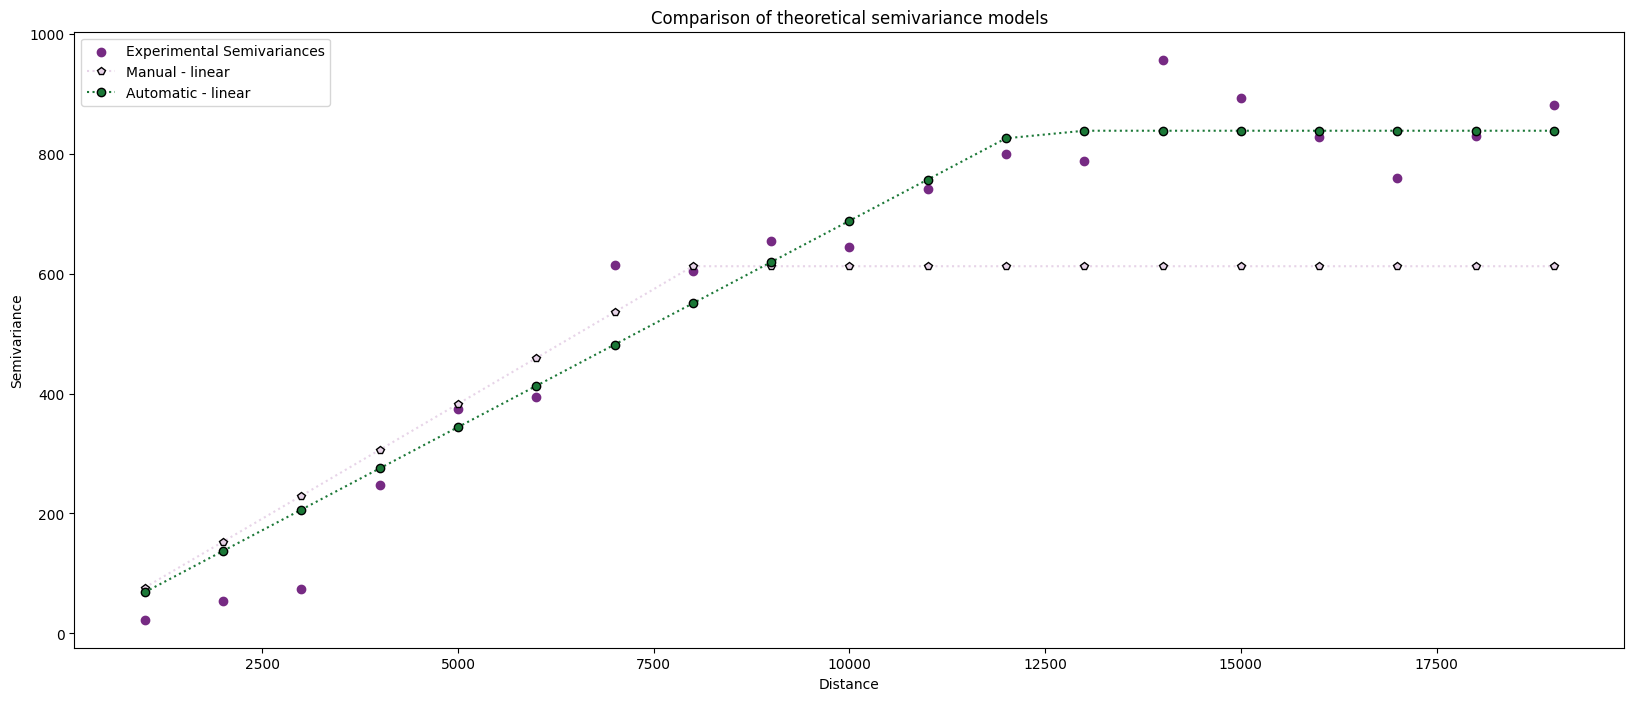

In [34]:
_lags = experimental_variogram.lags
_experimental = experimental_variogram.semivariances
_linear_manual = linear_model.yhat
_automatic = fitted.yhat

plt.figure(figsize=(20, 8))
plt.scatter(_lags, _experimental, color='#762a83')  # Experimental
plt.plot(_lags, _linear_manual, ':p', color='#e7d4e8', mec='black')
plt.plot(_lags, _automatic, ':o', color='#1b7837', mec='black')

plt.title('Comparison of theoretical semivariance models')
plt.legend(['Experimental Semivariances',
            'Manual - ' + linear_model.name,
            'Automatic - ' + fitted.name])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

## Chapter 5: Exporting model

Models could be exported and used for other purposes. It is vital for the semivariogram regularization. Those calculations are computationally intensive, and in production, it is not a good idea to regularize semivariogram every time when you run the Poisson Kriging pipeline. Moreover, theoretical model parameters should be traced and stored for reproducibility and explainability purposes.

Model can be exported to dict with `.to_dict()` method or to json with `.to_json()` methods.

In [35]:
dict_representation = fitted.to_dict()

In [36]:
dict_representation

{'experimental_variogram': None,
 'nugget': 0.0,
 'sill': 838.361859474651,
 'rang': 12183.276534598033,
 'variogram_model_type': 'linear',
 'direction': None,
 'spatial_dependence': None,
 'spatial_index': None,
 'yhat': None,
 'errors': None}

In [37]:
# Save to json

fitted.to_json('fitted.json')

## Chapter 6: Importing fitted model

We can import a semivariogram model into a `TheoreticalVariogram` class instance without passing the experimental semivariogram or actual data points. It is helpful for some applications focused on kriging, where we are sure that our semivariogram model fits data well.

We can import a model with two methods `.from_dict()` if we have our model parameters in the Python dictionary or `.from_json()` if model parameters are stored in a flat file:

In [38]:
model_from_dict = TheoreticalVariogram()
model_from_dict.from_dict(dict_representation)

In [39]:
print(model_from_dict)

* Selected model: Linear model
* Nugget: 0.0
* Sill: 838.361859474651
* Range: 12183.276534598033
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: 0.0
* Mean RMSE: 0.0
* Error-lag weighting method: None




In [40]:
model_from_json = TheoreticalVariogram()
model_from_json.from_json('fitted.json')

In [41]:
print(model_from_json)

* Selected model: Linear model
* Nugget: 0.0
* Sill: 838.361859474651
* Range: 12183.276534598033
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: 0.0
* Mean RMSE: 0.0
* Error-lag weighting method: None




That's all, well done!

-----

## Changelog

| Date       | Changes                                            | Author                           |
|------------|----------------------------------------------------|----------------------------------|
| 2025-09-16 | Removed `dir_neighbors_selection_method` parameter | @SimonMolinsky (Szymon Moliński) |
| 2025-02-15 | Tutorial has been adapted to the 1.0 release       | @SimonMolinsky (Szymon Moliński) |